In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip,  RandomBrightnessContrast
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Bidirectional, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, ZeroPadding2D,ConvLSTM2D,LSTM,GlobalAveragePooling2D, Reshape, Dense, Multiply, AveragePooling2D, UpSampling2D
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate,TimeDistributed, Add, add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications import InceptionResNetV2, DenseNet121, MobileNetV2,ResNet50,VGG16,VGG19, NASNetLarge,EfficientNetB7,EfficientNetV2S, EfficientNetV2M,EfficientNetV2L
from tensorflow.keras.metrics import Recall, Precision, Accuracy, MeanIoU
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

In [ ]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS=3
EPOCHS = 55
BATCH = 4
LR = 0.0001
shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
PATH = "/content/drive/MyDrive/Fydp-2/Dataset/BUS/"

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
# 1. Load the dataset
# 2. Use the albumentations library to augment the dataset.

import os
import cv2
from tqdm import tqdm
from glob import glob
from albumentations import CenterCrop, RandomRotate90, RGBShift,ShiftScaleRotate, GridDistortion,RandomGamma, HorizontalFlip,RandomBrightnessContrast, RandomBrightness, VerticalFlip, Transpose, Compose, HueSaturationValue, RandomContrast
from albumentations.augmentations.transforms import CLAHE, GaussNoise, FancyPCA

def load_data(path):
    images = sorted(glob(os.path.join(path, "original/*")))
    masks = sorted(glob(os.path.join(path, "GT/*")))
    return images, masks

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def augment_data(images, masks, save_path, augment=True):
    H = 256
    W = 256

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        """ Augmentation """
        if augment == True:
            #aug = CenterCrop(200, 200, p=1.0)
            #augmented = aug(image=x, mask=y)
            #x1 = augmented["image"]
            #y1 = augmented["mask"]

            aug = RandomRotate90(p=0.5)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = RandomRotate90(p=0.5)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = GridDistortion(p=0.5)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = HorizontalFlip(p=0.5)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            aug = VerticalFlip(p=0.5)
            augmented = aug(image=x, mask=y)
            x6 = augmented['image']
            y6 = augmented['mask']

            aug = Transpose(p=0.5)
            augmented = aug(image=x, mask=y)
            x7 = augmented['image']
            y7 = augmented['mask']

            aug = Compose([VerticalFlip(p=0.5),RandomRotate90(p=0.5)])
            augmented = aug(image=x, mask=y)
            x8 = augmented['image']
            y8 = augmented['mask']

            aug = RandomBrightnessContrast(p=0.5)
            augmented = aug(image=x, mask=y)
            x9 = augmented['image']
            y9 = augmented['mask']

            # aug = RandomGamma(p=1)
            # augmented = aug(image=x, mask=y)
            # x10 = augmented['image']
            # y10 = augmented['mask']

            # aug = HueSaturationValue(p=1)
            # augmented = aug(image=x, mask=y)
            # x11 = augmented['image']
            # y11 = augmented['mask']

            aug = RGBShift(p=0.5)
            augmented = aug(image=x, mask=y)
            x12 = augmented['image']
            y12 = augmented['mask']

            # aug = RandomBrightness(p=1)
            # augmented = aug(image=x, mask=y)
            # x13 = augmented['image']
            # y13 = augmented['mask']

            # aug = RandomContrast(p=1)
            # augmented = aug(image=x, mask=y)
            # x14 = augmented['image']
            # y14 = augmented['mask']

            aug = ShiftScaleRotate(p=0.5)
            augmented = aug(image=x, mask=y)
            x15 = augmented['image']
            y15 = augmented['mask']

            # aug = Compose([VerticalFlip(p=0.7),RandomBrightness(p=0.5), RandomGamma(p=0.5)])
            # augmented = aug(image=x, mask=y)
            # x16 = augmented['image']
            # y16 = augmented['mask']

            clip_limit=6.0
            aug = CLAHE(clip_limit, p=0.5)
            augmented = aug(image=x, mask=y)
            x17 = augmented['image']
            y17 = augmented['mask']

            # alpha=1.0
            # aug = FancyPCA(alpha, p=1.0)
            # augmented = aug(image=x, mask=y)
            # x18 = augmented['image']
            # y18 = augmented['mask']

            # var_limit=(10.0, 50.0)
            # mean=-50
            # aug = GaussNoise(var_limit, mean, p=1.0)
            # augmented = aug(image=x, mask=y)
            # x18 = augmented['image']
            # y18 = augmented['mask']

            # clip_limit=5.0
            # aug = CLAHE(clip_limit, p=1.0)
            # augmented = aug(image=x, mask=y)
            # x19 = augmented['image']
            # y19 = augmented['mask']

            # aug = HueSaturationValue(p=0.5)
            # augmented = aug(image=x, mask=y)
            # x20 = augmented['image']
            # y20 = augmented['mask']

            # aug = RandomBrightnessContrast(p=0.7)
            # augmented = aug(image=x, mask=y)
            # x21 = augmented['image']
            # y21 = augmented['mask']

            # aug = RandomGamma(p=0.5)
            # augmented = aug(image=x, mask=y)
            # x22 = augmented['image']
            # y22 = augmented['mask']


            # save_images = [x]
            # save_masks =  [y]

            save_images = [x, x2, x3, x4, x5, x6, x7, x8, x9, x12, x15, x17]
            save_masks =  [y, y2, y3, y4, y5, y6, y7, y8, y9, y12, y15, y17]

            # save_images = [x, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22]
            # save_masks =  [y, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14, y15, y16, y17, y18, y19, y20, y21, y22]

        else:
            save_images = [x]
            save_masks = [y]

        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"
            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1

if __name__ == "__main__":
    """ Loading original images and masks. """
    path = "/content/drive/MyDrive/Fydp-2/Dataset/BUS/"
    images, masks = load_data(path)
    print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")

    """ Creating folders. """
    create_dir("new_data/images")
    create_dir("new_data/masks")

    """ Applying data augmentation. """
    augment_data(images, masks, "new_data", augment=True)

    """ Loading augmented images and masks. """
    images, masks = load_data("new_data/")
    print(f"Augmented Images: {len(images)} - Augmented Masks: {len(masks)}")

Original Images: 163 - Original Masks: 163


100%|██████████| 163/163 [01:41<00:00,  1.61it/s]

Augmented Images: 0 - Augmented Masks: 0


In [ ]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "/content/new_data/images/*.png")))
    masks = sorted(glob(os.path.join(path, "/content/new_data/masks/*.png")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
# Previous preprocessing code

#def read_image(path):
#    path = path.decode()
#    x = cv2.imread(path, cv2.IMREAD_COLOR)
#    x = cv2.resize(x, (IMAGE_HEIGHT, IMAGE_WIDTH))
#    x = x/255.0
#    return x

# def read_mask(path):
#     path = path.decode()
#     x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     x = cv2.resize(x, (IMAGE_HEIGHT, IMAGE_WIDTH))
#     x = x/255.0
#     x = np.expand_dims(x, axis=-1)
#     return x

# def tf_parse(x, y):
#     def _parse(x, y):
#         x = read_image(x)
#         y = read_mask(y)
#         return x, y

#     x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
#     x.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, 3])
#     y.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, 2])
#     return x, y

# def tf_dataset(x, y, batch=4):
#     dataset = tf.data.Dataset.from_tensor_slices((x, y))
#     dataset = dataset.map(tf_parse)
#     dataset = dataset.batch(batch)
#     dataset = dataset.repeat()
#     return dataset

In [ ]:
# # New preprocessing code # #

def read_image(x):
    x = x.decode()
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(y):
    y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def parse_data(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        y = np.concatenate([y, y], axis=-1)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 2])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.map(map_func=parse_data)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  1566
Validation data:  195
Testing data:  195


In [ ]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

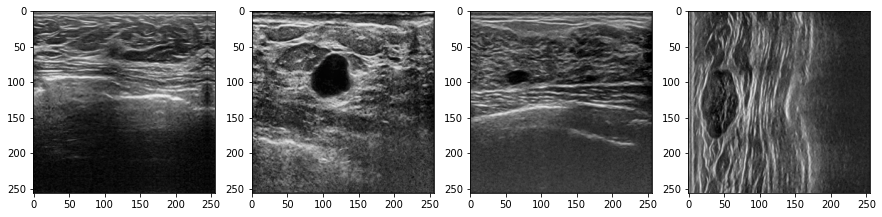

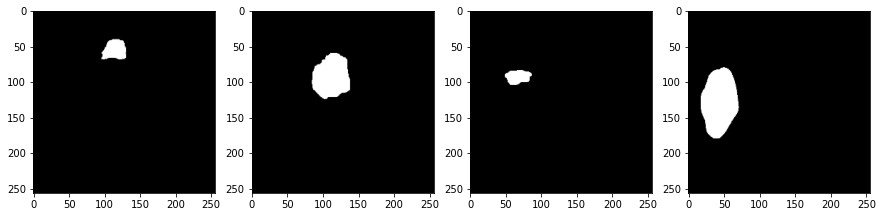

In [ ]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[1]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[10]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[61]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[9]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[1]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[10]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[61]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[9]))
imgplot.set_clim(0.0, 1.4)

In [ ]:
#inputs = tf.keras.layers.Input((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
#enet = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs)
#enet.summary()

In [ ]:
create_dir("files")
model_path = os.path.join("files", "BUS_DenseNet.hdf5")
csv_path = os.path.join("files", "BUS_DenseNet.hdf5")

In [ ]:
# Ref : https://github.com/bnsreenu/python_for_microscopists

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tf.keras.layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


In [ ]:
def squeeze_excite_block(filters,input):
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Reshape((1, filters))(se)
    se = tf.keras.layers.Dense(filters//16, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    se = tf.keras.layers.multiply([input, se])
    return se

In [ ]:
from tensorflow.keras.layers import SeparableConv2D
# Creating separable Conv-batch norm block

def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters, kernel_size=kernel_size, strides=strides,
              padding="same", use_bias=False) (x)
    x = BatchNormalization() (x)
    x = SeparableConv2D(filters=filters, kernel_size=kernel_size, strides=strides,
              padding="same", use_bias=False) (x)
    x = BatchNormalization() (x)
    return x

In [ ]:
def REASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, padding="same")(x)
    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y2)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)
    y2 = Conv2D(filter, 1, padding="same")(y2)
    y2 = add([y2, x])

    y3 = Conv2D(filter, 1, padding="same")(x)
    y3 = Conv2D(filter, 3, dilation_rate=2, padding="same", use_bias=False)(y3)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)
    y3 = Conv2D(filter, 1, padding="same")(y3)
    y3 = add([y3, x])

    y4 = Conv2D(filter, 1, padding="same")(x)
    y4 = Conv2D(filter, 3, dilation_rate=4, padding="same", use_bias=False)(y4)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)
    y4 = Conv2D(filter, 1, padding="same")(y4)
    y4 = add([y4, x])

    y5 = Conv2D(filter, 1, padding="same")(x)
    y5 = Conv2D(filter, 3, dilation_rate=8, padding="same", use_bias=False)(y5)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)
    y5 = Conv2D(filter, 1, padding="same")(y5)
    y5 = add([y5, x])

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, add
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, AvgPool2D
from tensorflow.keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras.layers import ReLU, concatenate

import tensorflow as tf

# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277


inputs = Input((256, 256, 3))

s = Lambda(lambda x: x / 255) (inputs)




def DenseNet(x, repetition, filters, strides=1):
  for _ in range(repetition):
    x = BatchNormalization() (x)
    x = ReLU()(x)
    y = Conv2D(4*filters, 1, strides = strides, padding="same") (x)
    y = Conv2D(filters, 3, activation='relu', padding="same") (y)
    x = concatenate([y,x])
    return x




def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out1 = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = conv2d_bn(inp, filters, 5, 5, activation ='relu', padding='same')

    out = add([shortcut, out1, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out1 = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = conv2d_bn(out, filters, 5, 5, activation ='relu', padding='same')

        out = add([shortcut, out1, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1_1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1_2 = Conv2D(16, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1_3 = Conv2D(16, (7, 7), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
# add/concate
c1 = add([c1_1, c1_2, c1_3])

# s1 = sep_bn(c1, 32, (3,3))
# s1 = Dropout(0.1) (s1)
# c1 = BatchNormalization()(c1)
#c1 = DenseNet(c1, 2, 16)
# c1 = SeparableConv2D(filters=32, kernel_size=3, strides=1,padding="same", use_bias=False) (c1)
# c1 = Dropout(0.1) (c1)

# c1 = SeparableConv2D(filters=64, kernel_size=3, strides=1,padding="same", use_bias=False) (c1)
# c1 = Dropout(0.1) (c1)

# c1 = SeparableConv2D(filters=128, kernel_size=3, strides=1,padding="same", use_bias=False) (c1)
# c1 = Dropout(0.1) (c1)

c1 = DenseNet(c1, 2, 32)
# c1 = concatenate([s1, d1])
c1 = Dropout(0.1) (c1)
c1 = squeeze_excite_block(48, c1)
p1 = MaxPooling2D((2, 2)) (c1)
c1 = ResPath(16, 4, c1)


c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2_1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2_2 = Conv2D(32, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2_3 = Conv2D(32, (7, 7), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
# add/concate
c2 = add([c2_1, c2_2, c2_3])
# c2 = BatchNormalization(axis=3)(c2)


# s2 = sep_bn(c2, 64, (3,3))
#c2 = DenseNet(c2, 2, 32)
# c2 = SeparableConv2D(filters=32, kernel_size=3, strides=1,padding="same", use_bias=False) (c2)
# c2 = Dropout(0.1) (c2)

# c2 = SeparableConv2D(filters=64, kernel_size=3, strides=1,padding="same", use_bias=False) (c2)
# c2 = Dropout(0.1) (c2)

# c2 = SeparableConv2D(filters=128, kernel_size=3, strides=1,padding="same", use_bias=False) (c2)
# c2 = Dropout(0.1) (c2)

c2 = DenseNet(c2, 2, 64)
c2 = Dropout(0.1) (c2)
# c2 = concatenate([s2, d2])

c2 = squeeze_excite_block(96, c2)
# squeeze_excite_block(256,c5)
p2 = MaxPooling2D((2, 2)) (c2)
c2 = ResPath(32, 3, c2)

# c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
# c2 = Dropout(0.1) (c2)
# c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
# c2 = BatchNormalization(axis=3)(c2)
# c2 = model_inception(c2)
# # squeeze_excite_block(256,c5)
# p2 = MaxPooling2D((2, 2)) (c2)
# c2 = ResPath(32, 3, c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3_1 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3_2 = Conv2D(64, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3_3 = Conv2D(64, (7, 7), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
# add/concate
c3 = add([c3_1, c3_2, c3_3])

#c3 = DenseNet(c3, 2, 64)
# s3 = sep_bn(c3, 64, (3,3))

# c3 = SeparableConv2D(filters=32, kernel_size=3, strides=1,padding="same", use_bias=False) (c3)
# c3 = Dropout(0.1) (c3)

# c3 = SeparableConv2D(filters=64, kernel_size=3, strides=1,padding="same", use_bias=False) (c3)
# c3 = Dropout(0.1) (c3)

# c3 = SeparableConv2D(filters=128, kernel_size=3, strides=1,padding="same", use_bias=False) (c3)
# c3 = Dropout(0.1) (c3)

c3 = DenseNet(c3, 2, 64)
c3 = Dropout(0.2) (c3)
# c3 = concatenate([s3, d3])
c3 = squeeze_excite_block(128, c3)
p3 = MaxPooling2D((2, 2)) (c3)
c3 = ResPath(64, 2, c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
c4_2 = Conv2D(128, (5, 5), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
c4_3 = Conv2D(128, (7, 7), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
# add/concate
c4 = add([c4_1, c4_2, c4_3])
# c4 = BatchNormalization(axis=3)(c4)
# s4 = sep_bn(c4, 128, (3,3))

# c4 = SeparableConv2D(filters=32, kernel_size=3, strides=1,padding="same", use_bias=False) (c4)
# c4 = Dropout(0.1) (c4)

# c4 = SeparableConv2D(filters=64, kernel_size=3, strides=1,padding="same", use_bias=False) (c4)
# c4 = Dropout(0.1) (c4)

# c4 = SeparableConv2D(filters=128, kernel_size=3, strides=1,padding="same", use_bias=False) (c4)
# c4 = Dropout(0.1) (c4)
c4 = DenseNet(c4, 2, 128)
c4 = Dropout(0.2) (c4)
# c4 = concatenate([s4, d4])
c4 = squeeze_excite_block(256, c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
c4 = ResPath(128, 1, c4)


c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

c5 = REASPP(c5, 256)

'''p5_1 = MaxPooling2D(pool_size=(1,1))(c5)
c5_1 = Conv2D(256, (1, 1), activation='elu', kernel_initializer='he_normal', padding='same')(p5_1)
p5_2 = MaxPooling2D(pool_size=(2,2))(c5)
c5_2 = Conv2D(256, (1, 1), activation='elu', kernel_initializer='he_normal', padding='same')(p5_2)
p5_3 = MaxPooling2D(pool_size=(3,3))(c5)
c5_3 = Conv2D(256, (1, 1), activation='elu', kernel_initializer='he_normal', padding='same')(p5_3)
p5_4 = MaxPooling2D(pool_size=(6,6))(c5)
c5_4 = Conv2D(256, (1, 1), activation='elu', kernel_initializer='he_normal', padding='same')(p5_4)

c5_1_1 = concatenate([c5_1, c5_2, c5_3, c5_4])

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5_1_1)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)


c5 = Conv2D(256, (1, 1), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u9 = add([u9, c5])


u9 = squeeze_excite_block(16,u9)'''


u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(2, (1, 1), activation='sigmoid') (u9)

model = Model(inputs=[inputs], outputs=[outputs])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

opt = tf.keras.optimizers.Nadam(LR)
metrics = ['accuracy', dice_coef, Recall(), Precision(), iou, MeanIoU(num_classes=2)]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False)]

In [ ]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

hist=model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/55
392/392 [==============================] - 170s 348ms/step - loss: 0.3812 - accuracy: 0.7058 - dice_coef: 0.6188 - recall: 0.6598 - precision: 0.4490 - iou: 0.4818 - mean_io_u: 0.5198 - val_loss: 1.0000 - val_accuracy: 0.8314 - val_dice_coef: 5.1571e-06 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 2.5788e-06 - val_mean_io_u: 0.4773 - lr: 1.0000e-04
Epoch 2/55
392/392 [==============================] - 134s 343ms/step - loss: 0.2358 - accuracy: 0.8249 - dice_coef: 0.7642 - recall: 0.7460 - precision: 0.8199 - iou: 0.6403 - mean_io_u: 0.6830 - val_loss: 0.3659 - val_accuracy: 0.8689 - val_dice_coef: 0.6341 - val_recall: 0.4975 - val_precision: 0.8989 - val_iou: 0.4987 - val_mean_io_u: 0.6494 - lr: 1.0000e-04
Epoch 3/55
392/392 [==============================] - 134s 342ms/step - loss: 0.1870 - accuracy: 0.8799 - dice_coef: 0.8130 - recall: 0.7769 - precision: 0.8693 - iou: 0.7002 - mean_io_u: 0.7697 - val_loss: 0.3334 - val_accuracy: 0.8915 - val_dice_coef: 

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

49/49 [==============================] - 5s 106ms/step - loss: 0.0442 - accuracy: 0.8504 - dice_coef: 0.9558 - recall: 0.9314 - precision: 0.9766 - iou: 0.9166 - mean_io_u: 0.9518


[0.04419591650366783,
 0.8504290580749512,
 0.9558039307594299,
 0.9314481616020203,
 0.9766080379486084,
 0.9165700674057007,
 0.9517730474472046]

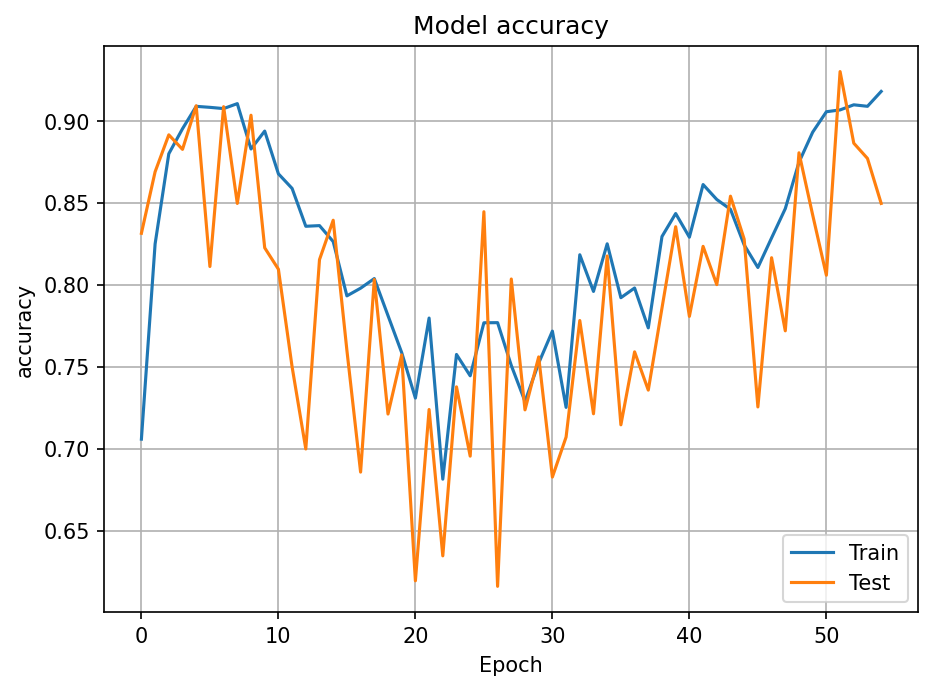

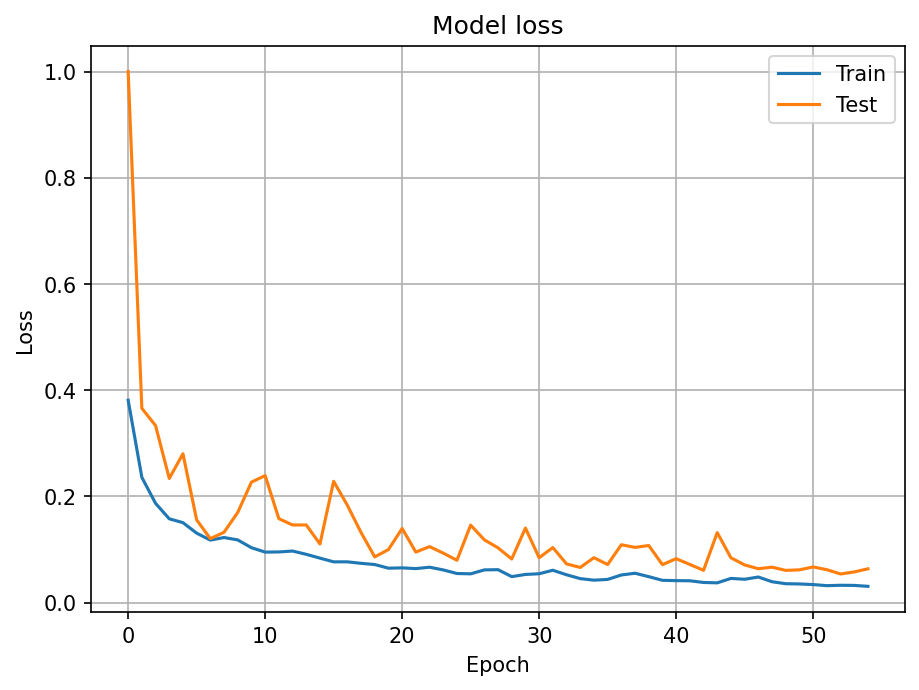

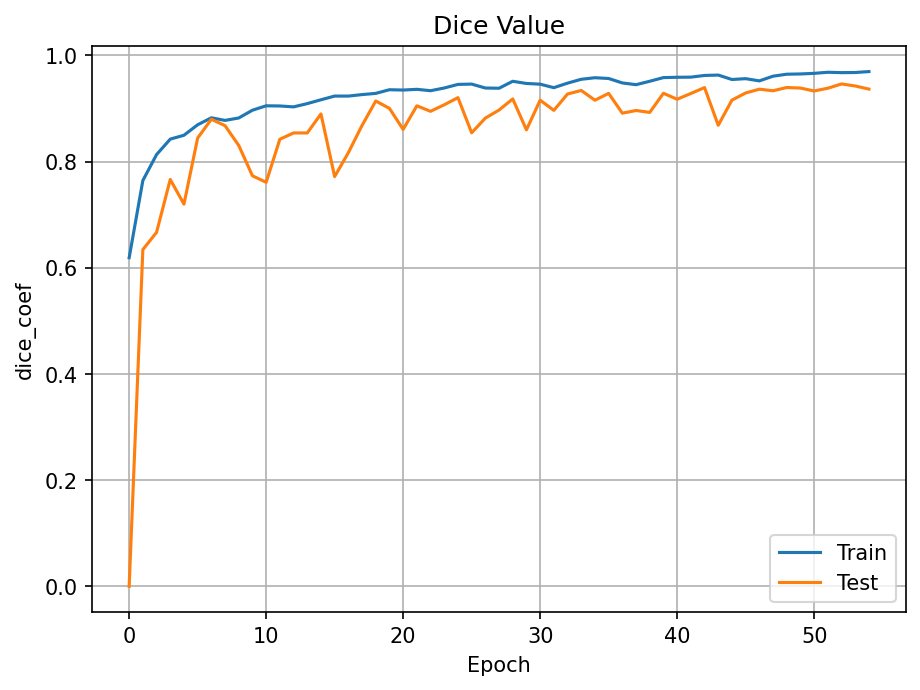

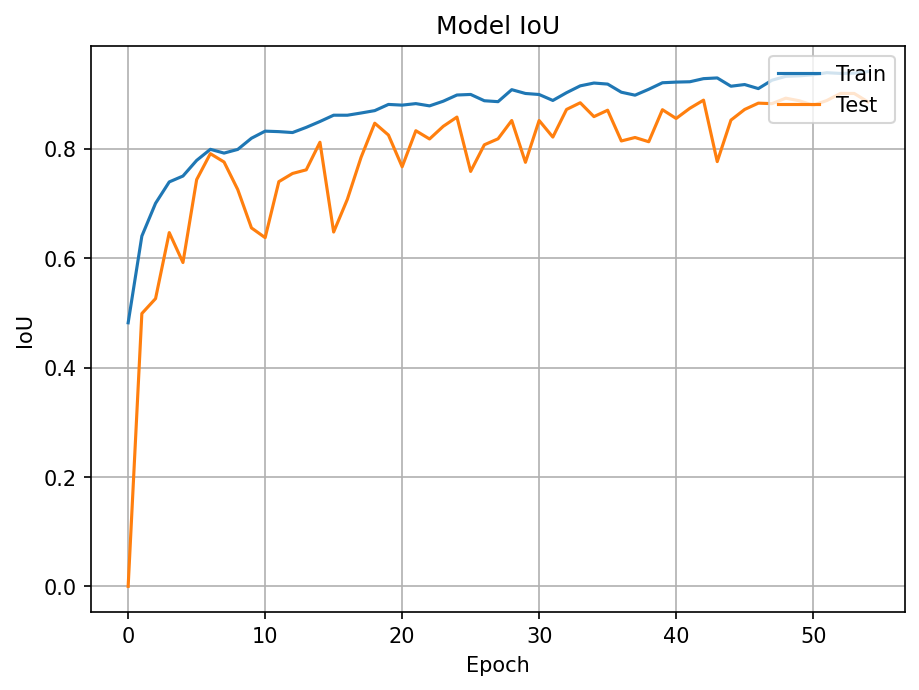

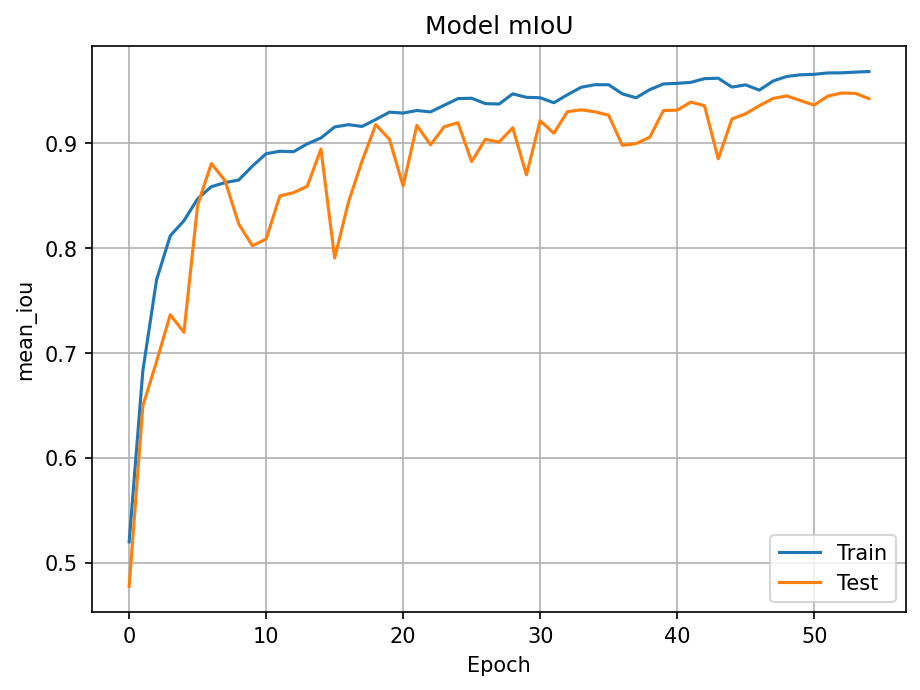

In [ ]:
# Plot training & validation loss values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid('on')
plt.show()


# Plot training & validation loss values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid('on')
plt.show()

# Plot training & validation accuracy values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('Dice Value')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid('on')
plt.show()


# Plot training & validation loss values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['iou'])
plt.plot(hist.history['val_iou'])
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid('on')
plt.show()


# Plot training & validation iou values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['mean_io_u'])
plt.plot(hist.history['val_mean_io_u'])
plt.title('Model mIoU')
plt.ylabel('mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid('on')
plt.show()


In [ ]:
# # New code # #

def read_image(x):
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    return image

def read_mask(y):
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask.astype(np.float32)
    mask = mask/255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

def parse(y_pred):
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = y_pred[..., -1]
    y_pred = y_pred.astype(np.float32)
    y_pred = np.expand_dims(y_pred, axis=-1)
    return y_pred


In [ ]:
import os
import numpy as np
import cv2
import json
from glob import glob
#from metrics import *
from sklearn.utils import shuffle
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
#from model import build_model, Upsample, ASPP

def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def read_data(x, y):
    """ Read the image and mask from the given path. """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

def read_params():
    """ Reading the parameters from the JSON file."""
    with open("params.json", "r") as f:
        data = f.read()
        params = json.loads(data)
        return params

def load_data(path):
    """ Loading the data from the given path. """
    images_path = os.path.join(path, "image/*")
    masks_path  = os.path.join(path, "mask/*")

    images = glob(images_path)
    masks  = glob(masks_path)

    return images, masks

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_model_weight(path):
    with CustomObjectScope({
        'dice_loss': dice_loss,
        'dice_coef': dice_coef,
        'bce_dice_loss': bce_dice_loss,
        'focal_loss': focal_loss,
        'iou': iou
        }):
        model = load_model(path)
    return model
    # model = build_model(256)
    # model.load_weights(path)
    # return model

In [ ]:
model.save('/content/drive/MyDrive/Fydp-1 Biomedical Image Segmentation/Results/BUS_DenseNet.hdf5')

In [ ]:
def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def evaluate_normal(model, x_data, y_data):
    THRESHOLD = 0.5
    total = []
    for i, (x, y) in tqdm(enumerate(zip(x_data, y_data)), total=len(x_data)):
        x = read_image(x)
        y = read_mask(y)
        _, h, w, _ = x.shape

        y_pred1 = parse(model.predict(x)[0][..., -2])
        y_pred2 = parse(model.predict(x)[0][..., -1])

        line = np.ones((h, 10, 3)) * 255.0

        all_images = [
            x[0] * 255.0, line,
            mask_to_3d(y) * 255.0, line,
            mask_to_3d(y_pred1) * 255.0, line,
            mask_to_3d(y_pred2) * 255.0
        ]
        mask = np.concatenate(all_images, axis=1)

        #cv2.imwrite(f"results/{i}.png", mask)
        cv2.imwrite(f"/content/drive/MyDrive/Fydp-1 Biomedical Image Segmentation/Results/BUS_DenseNet_Result/{i}.png", mask)

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

if __name__ == "__main__":
    np.random.seed(42)
    tf.random.set_seed(42)
    #create_dir("results/")
    create_dir("/content/drive/MyDrive/Fydp-1 Biomedical Image Segmentation/Results/BUS_DenseNet_Result/")

    batch_size = 4

    # test_path = "../1/new_data/test/"
    # test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
    # test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))
    test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

    test_steps = (len(test_x)//batch_size)
    if len(test_x) % batch_size != 0:
        test_steps += 1

    model = load_model_weight("/content/drive/MyDrive/Fydp-1 Biomedical Image Segmentation/Results/BUS_DenseNet.hdf5")
    #model.evaluate(test_dataset, steps=test_steps)
    evaluate_normal(model, test_x, test_y)